## Problem Set 4
### Recommendation System Analysis and Implementation
#### Jiashu Chen
#### 03/05/2023

### Content

#### Question 1: DataSet

The dataset I chose is the MovieLens dataset. It is one of the most popular dataset used for recommendation system.

#### Question 2: Research Questions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit

### Part I: Import Data

In [3]:
col_names = ['user_id', "item_id", "rating", "timestamp"]
data = pd.read_csv("/Users/jiashu/Desktop/574Final/ml-100k/u.data", sep = '\t', header = None, names = col_names)

In [4]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
col_names2 = d.split(' | ')
items = pd.read_csv("/Users/jiashu/Desktop/574Final/ml-100k/u.item", sep = '|', header = None, names = col_names2)
movies = items[["movie id", "movie title"]]
movies = movies.rename(columns = {"movie id" : "item_id", "movie title" : "movie_title"})
df = pd.merge(data, movies, on = 'item_id')

In [5]:
df.head()

,user_id,item_id,rating,timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [6]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Num of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num of Users: 943
Num of Movies: 1682


In [7]:
# Functionality: creating mapping between two columns of the dataframe
# Input: 
    # data: rating records
    # col1_name: the name of one column
    # col2_name: the name of the other column
    
def mapping(data, col1_name, col2_name):
    unique = data[[col1_name, col2_name]].drop_duplicates()
    colmap = dict(zip(unique[col1_name], unique[col2_name]))
    return colmap

In [8]:
movie_map = mapping(df, "item_id", "movie_title")

### PART II: Training Testing Split

To evaluate the Recommendation System model, the entire dataset split into the training_data and testing_data. Different from evaluation of some algorithm models, there is no split between label and predictors. This is because the RS model is evaluated based on differences between predicted movie rating and actual movie rating. The rating is predictor as well as the label.

The test_size is set at 0.25, which means that 75% of total ratings is in the training set and 25% of total ratings is in the testing set.

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.25)

### PART III: Model Development 
- 3.1 Model-Based Collaborative Filtering
   - 3.1.1 Sample Model with K = 10
   - 3.1.2 Hyperparameter Tuning on No.Latent Factors
- 3.2 Momery-Based Collaborative Filtering
   - 3.2.1 Sample Model with K = 20
   - 3.2.2 Hyperparameter Tuning on No.Neighbors

The current data is a collection of rating record. To perform collaborative filtering, a matrix is needed. The columns of the matrix are movies and the rows of the matrix are users. (i, j) value indicates the rating from the ith user to the jth movie. Therefore, the matrix should be in the shape (numOfUsers, numOfMovies).

In [17]:
user_to_movie_df = np.zeros((n_users, n_items))
for row in df.itertuples():
    user_to_movie_df[row[1]-1, row[2]-1] = row[3]

In [18]:
user_to_movie_df

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

#### 3.1 Model-Based Collaborative Filtering

Model-Based Collaborative Filtering is based on matrix factorization. In this project, Singular Value Decomposition(SVD) techniques are used for matrix factorization

with SVD, the original data matrix is decomposed into three matrices. 
- U: represents relationships between users and latent factors.
- S: represents strength of each latent factor.
- V: represents relationships between items and latent factors.

In [35]:
from scipy.linalg import sqrtm

##### 3.1.1 Sample Model with K = 10
In the following model, k is set to be 10, which represents the number of latent factors used in the model.

In [157]:
# creating utility matrix
train_data_matrix = np.asarray([[np.nan for j in range(n_items)] for i in range(n_users)])
for row in train_data.itertuples():
    train_data_matrix[row[1]-1, row[2]-1] = row[3]

In [40]:
# Function: fill in matrix NA values with item mean rating, and normalize each column
# Input: user-item matrix where NA represents no rating record
# Output: normalized matrix, user mean ratings, item mean ratings
def matrixTransform(m):
    mask = np.isnan(m) # mask used to label NA cells
    masked_arr = np.ma.masked_array(m, mask)
    item_means = np.mean(masked_arr, axis=0) # meaning rating for items based on existing ratings
    user_means = np.mean(masked_arr, axis=1) # meaning rating given by users based on existing ratings
    filled_matrix = masked_arr.filled(item_means) # fill NA values with item mean rating
    filled_matrix = filled_matrix - item_means.data[np.newaxis,:] # normalize item ratings
    util_matrix = filled_matrix/np.sqrt(len(m[0]) -1)
    return util_matrix, user_means, item_means

In [41]:
train_data_matrix_normed, user_mean, item_mean = matrixTransform(train_data_matrix)

In [42]:
train_data_matrix_normed

array([[ 0.02785437, -0.00711382,  0.02291205, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00346412,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02785437,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.04166667,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

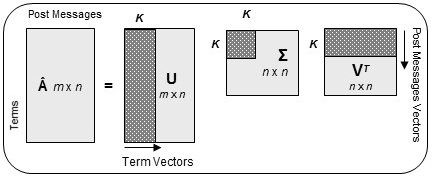

In [394]:
# Function: perform SVD on matrix, extract k latent factors
# Input: utilMat: normalized user-item matrix, 
#        k: the number of latent factors used
#        item_mean: item mean rating
# Output: truncated SVD
def svd(utilMat, k, item_mean):
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    # add item mean rating subtracted in previous normalization
    svdout = UsV + item_mean.data[np.newaxis:, ]
    return svdout

In [47]:
svdout = svd(train_data_matrix_normed, 10, item_mean)

In [48]:
svdout

array([[3.86636814, 3.2909507 , 3.06110349, ..., 2.        , 0.        ,
        0.        ],
       [3.86048038, 3.29181979, 3.06079465, ..., 2.        , 0.        ,
        0.        ],
       [3.85458878, 3.29140631, 3.0590602 , ..., 2.        , 0.        ,
        0.        ],
       ...,
       [3.86234516, 3.29231252, 3.06161732, ..., 2.        , 0.        ,
        0.        ],
       [3.86194068, 3.2940903 , 3.06133784, ..., 2.        , 0.        ,
        0.        ],
       [3.85696738, 3.28942727, 3.0606647 , ..., 2.        , 0.        ,
        0.        ]])

The above SVD output matrix is predicted rating from each user on each item.

To evaluate the model, the performance is calculated by comparing the predicted rating and the test_matrix rating. Since the test_matrix contains 25% of rating records, we need to filter out all predicted ratings that do not exist in the test data, which are zero values in the test_matrix.

The metric used for measure performance is the Root Mean Squared Error (RMSE) 
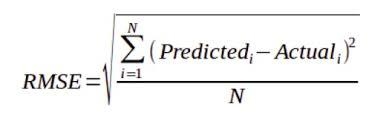

In [53]:
import math
def rmse(true, pred):
    x = true - pred
    return math.sqrt(sum([xi*xi for xi in x])/len(x))

In [57]:
min(test_data['user_id']), min(test_data['item_id'])

(1, 1)

In [59]:
pd.DataFrame(svdout)

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.866368,3.290951,3.061103,3.559352,3.345722,3.564760,3.818041,4.032521,3.989615,3.787511,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
1,3.860480,3.291820,3.060795,3.553761,3.348164,3.562804,3.806850,4.030949,3.983091,3.786160,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
2,3.854589,3.291406,3.059060,3.551631,3.347414,3.561532,3.801641,4.030337,3.980721,3.785042,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
3,3.863518,3.291700,3.061946,3.553058,3.348748,3.563236,3.810192,4.029299,3.981445,3.786668,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
4,3.850209,3.288214,3.059801,3.549617,3.346480,3.563786,3.816109,4.026527,3.982773,3.786308,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,3.865158,3.293414,3.063044,3.554888,3.350255,3.561933,3.809613,4.031570,3.981087,3.785895,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
939,3.856291,3.292047,3.060980,3.551198,3.349585,3.561481,3.806751,4.027508,3.976656,3.784784,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
940,3.862345,3.292313,3.061617,3.553804,3.348789,3.562862,3.808321,4.030044,3.981103,3.786288,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
941,3.861941,3.294090,3.061338,3.555522,3.349920,3.563223,3.804180,4.032099,3.982966,3.786261,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0


In [60]:
pred = []
for _,row in test_data.iterrows():
    user = row['user_id']
    item = row['item_id']
    # userid and itemid in test_data starts from 1
    # need to subtract 1 from it t get the correct prediction
    pred_rating = svdout[user-1][item-1] 
    pred.append(pred_rating)

In [64]:
model1_rmse = rmse(test_data['rating'], pred)
model1_rmse 

1.0259706214247635

In [265]:
print("RMSE of the Model-Based Collaborative Filtering Model (k = 10): " + str(model1_rmse))

RMSE of the Model-Based Collaborative Filtering Model (k = 10): 1.0259706214247635


##### 3.1.2 Hyperparameter Tuning on Latent Factors

The above model with K = 10 gives us a RMSE of 1.025. We could adjust the k value for potential improvement.

In [97]:
def svd_k(k):
    svdout = svd(train_data_matrix_normed, k, item_mean)
    pred = []
    for _,row in test_data.iterrows():
        user = row['user_id']
        item = row['item_id']
        pred_rating = svdout[user-1][item-1] 
        pred.append(pred_rating)
    rmse_k = rmse(test_data['rating'], pred)
    return pred, rmse_k

In [272]:
rmse_res = pd.DataFrame({'k':[], 'rmse':[]})
for k in range(1, 50):  
    pred, k_rmse = svd_k(k)
    rmse_res = rmse_res.append({'k': k, 'rmse': k_rmse}, ignore_index=True)

Text(0.5, 1.0, 'SVD Number of Latent Factors vs. RMSE')

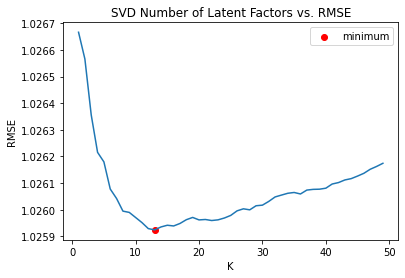

In [273]:
min_x = np.argmin(rmse_res.rmse) + 1
min_y = np.min(rmse_res.rmse)

plt.plot(rmse_res['k'], rmse_res['rmse'])
plt.scatter(min_x, min_y,c='r', label='minimum')
plt.legend()
plt.xlabel('K')
plt.ylabel("RMSE")
plt.title("SVD Number of Latent Factors vs. RMSE")

In [274]:
min_x, min_y

(13, 1.0259239677645815)

In [277]:
#k = 13
model2_start = timeit.default_timer()
model2_pred, model2_rmse  = svd_k(12)
model2_end = timeit.default_timer()
model2_time = model2_end - model2_start
print("RMSE of the Model-Based Collaborative Filtering Model (k = 13): " + str(model2_rmse))
print("Time Cost of the Model-Based Collaborative Filtering Model (k = 13): " + str(model2_time))

RMSE of the Model-Based Collaborative Filtering Model (k = 13): 1.0259289191067107
Time Cost of the Model-Based Collaborative Filtering Model (k = 13): 1.3447847079951316


#### 3.2 Memory-Based Collaborative Filtering

Memory-Based Collaborative Filtering utilizes similarity among users and items to provide recommendation. It could be further divided into Item-Based Collaborative Filtering and User-Based Collaborative Filtering.
   - Item-Based Collaborative Filtering: movies that are similar to users liked.
   - User-Based Collaborative Filtering: movies that liked by similar users

The KNN algorithm is used to choose close users.

In [12]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [158]:
train_data_matrix_zero = pd.DataFrame(train_data_matrix).fillna(0)

In [159]:
train_data_matrix_sparse = csr_matrix(train_data_matrix_zero)
train_data_matrix_sparse

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 75000 stored elements in Compressed Sparse Row format>

In [160]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(train_data_matrix_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [162]:
# Test on a random user
user = 21
n = 10
knn_input = np.asarray([train_data_matrix_zero .values[user-1]])

In [206]:
distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
similar_user_list = indices.flatten()[1:]
distance_list = distances.flatten()[1:]

In [207]:
indices

array([[ 20, 813, 365, 371, 421, 367, 254, 366, 924, 801, 545]])

In [208]:
distances

array([[0.        , 0.54556927, 0.55846472, 0.56236934, 0.61939093,
        0.63661066, 0.64670973, 0.65760414, 0.65988597, 0.66355461,
        0.68504022]])

In [210]:
print("Top",n,"users similar to the User",user, ":")
print(" ")
print("    User         Distance")
for i in range(1,len(distances[0])):
    print(i," ", indices[0][i],"     ",distances[0][i])

Top 10 users similar to the User 109 :
 
    User         Distance
1   813       0.5455692668146346
2   365       0.5584647230927977
3   371       0.5623693415356845
4   421       0.6193909265210742
5   367       0.6366106605257329
6   254       0.6467097331953643
7   366       0.6576041376191388
8   924       0.6598859736613073
9   801       0.6635546061412334
10   545       0.685040217395114


To predict one user's rating on a specific movie, we need to give different weights to different neighbors based on similarity.

In [165]:
# weights of neighbors
neighbor_weight_list = distance_list/np.sum(distance_list)
neighbor_weight_list

array([0.08749828, 0.08956645, 0.09019268, 0.09933779, 0.10209948,
       0.10371917, 0.10546641, 0.10583237, 0.10642075, 0.10986661])

We need to extract ratings given by neighbors. For movies that neighbors did not see, place the zero with movie mean rating.

In [168]:
mask = np.isnan(train_data_matrix)
masked_arr = np.ma.masked_array(train_data_matrix, mask)
train_data_matrix_mean = masked_arr.filled(item_mean) 

In [175]:
# extract ratings given by neighbors
neighbor_rating = train_data_matrix_mean[similar_user_list]
neighbor_rating.shape

(10, 1682)

In [176]:
# broadcast the neighbor weight to a matrix
weight_matrix = neighbor_weight_list[:,np.newaxis] + np.zeros(n_items)
weight_matrix.shape

(10, 1682)

In [177]:
# compute neighbor rating with weight
neighor_weight_rating = weight_matrix*neighbor_rating
neighor_weight_rating.shape

(10, 1682)

In [178]:
# sum up weighted neighbot rating
user_pred_rating = neighor_weight_rating.sum(axis =0)
user_pred_rating

array([4.07634689, 3.53274006, 3.06060606, ..., 2.        , 0.        ,
       0.        ])

The user_pred_rating gives us predicted ratings on all movies by the user. To test the model, we could compute predicted ratings for all users and then use the test_data to compute rmse

In [211]:
# summarize previous procedures into functions
def get_neighbors(user, n = 10):
    knn_input = np.asarray([train_data_matrix_zero .values[user-1]])
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    similar_user_list = indices.flatten()[1:]
    distance_list = distances.flatten()[1:]
    neighbor_weight_list = distance_list/np.sum(distance_list)
    return similar_user_list, neighbor_weight_list

In [212]:
def predict_user_rating(user, n = 10):
    similar_user_list, neighbor_weight_list = get_neighbors(user, n)
    neighbor_rating = train_data_matrix_mean[similar_user_list]
    weight_matrix = neighbor_weight_list[:,np.newaxis] + np.zeros(n_items)
    neighor_weight_rating = weight_matrix*neighbor_rating
    user_pred_rating = neighor_weight_rating.sum(axis =0)
    return user_pred_rating

In [213]:
# create a new matrix contain all users' predicted ratings
row_list = []
for user in range(n_users):
    itemPred = predict_user_rating(user)
    row_list.append(itemPred)
knn_pred = pd.DataFrame(row_list)

In [215]:
knn_pred

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.924128,3.208687,3.133694,3.521134,3.273904,3.562500,3.736417,3.612495,3.992860,3.706534,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
1,4.299634,3.321763,2.838497,3.822294,3.272599,3.562500,4.075196,4.401070,4.289827,4.051684,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
2,3.836325,3.291667,3.060606,3.552795,3.348485,3.562500,4.004617,4.029762,4.495158,3.725807,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
3,3.857971,3.291667,3.060606,3.552795,3.348485,3.562500,3.805461,4.029762,3.981308,3.785714,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
4,3.772190,3.291667,3.060606,3.552795,3.348485,3.562500,3.825303,4.029762,3.983215,3.785714,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,3.460948,3.291667,3.343841,3.552795,3.348485,3.562500,3.416584,4.029762,3.689207,3.785714,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
939,3.655026,3.291667,2.954566,3.552795,3.348485,3.306299,3.367715,4.029762,2.998198,3.723682,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
940,3.724041,3.100490,3.060606,3.972799,3.210863,3.410403,3.998340,4.101767,4.089504,3.785714,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0
941,3.575094,3.291667,3.054411,3.552795,3.348485,3.562500,4.024088,4.029762,3.880084,3.785714,...,0.0,4.0,0.0,2.0,3.0,1.0,3.0,2.0,0.0,0.0


In [219]:
knn_pred_list = []
for _,row in test_data.iterrows():
    user = row['user_id'] - 1
    item = row['item_id'] - 1
    pred_rating = knn_pred.iloc[user][item]
    knn_pred_list.append(pred_rating)

1.035943988821074


In [221]:
model3_rmse = rmse(test_data['rating'], knn_pred_list)
print("RMSE of the Memory-Based Collaborative Filtering Model (n = 10): " + str(model3_rmse))

RMSE of the Memory-Based Collaborative Filtering Model (n = 10): 1.035943988821074


##### 3.2.2 Hyperparameter Tuning on k Neighbors

The above model with k = 10 gives us a RMSE of 1.035. We could adjust the k value for potential improvement

In [223]:
def knn_matrix(k):
    row_list = []
    for user in range(n_users):
        itemPred = predict_user_rating(user, k)
        row_list.append(itemPred)
    knn_mat = pd.DataFrame(row_list)
    return knn_mat

In [224]:
def knn_k(k):
    knn_mat = knn_matrix(k)
    pred = []
    for _,row in test_data.iterrows():
        user = row['user_id']
        item = row['item_id']
        pred_rating = knn_mat.iloc[user-1][item-1] 
        pred.append(pred_rating)
    rmse_k = rmse(test_data['rating'], pred)
    return pred, rmse_k

In [259]:
rmse_res = pd.DataFrame({'k':[], 'rmse':[]})
for k in [10, 30, 50, 100, 200, 300, 500, 800, n_users-1
         ]:  
    pred, k_rmse = knn_k(k)
    rmse_res = rmse_res.append({'k': k, 'rmse': k_rmse}, ignore_index=True)

In [260]:
rmse_res

,k,rmse
0,10.0,1.035944
1,30.0,1.030327
2,50.0,1.029308
3,100.0,1.028334
4,200.0,1.027871
5,300.0,1.027642
6,500.0,1.027554
7,800.0,1.027458
8,942.0,1.027389


Text(0, 0.5, 'RMSE')

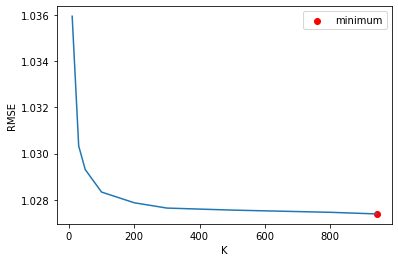

In [261]:
knn_min_x = rmse_res.loc[np.argmin(rmse_res.rmse)]['k']
knn_min_y = np.min(rmse_res.rmse)

plt.plot(rmse_res['k'], rmse_res['rmse'])
plt.scatter(knn_min_x, knn_min_y,c='r', label='minimum')
plt.legend()
plt.xlabel('K')
plt.ylabel("RMSE")

In [262]:
knn_min_x, knn_min_y

(942.0, 1.0273885966031988)

In [263]:
# 200 seems to be the elbow
# k = 200
model4_start = timeit.default_timer()
model4_pred, model4_rmse = knn_k(k)
model4_end = timeit.default_timer()
model4_time = model4_end - model4_start
print("RMSE of the Model-Based Collaborative Filtering Model (k = 13): " + str(model4_rmse))
print("Time Cost of the Model-Based Collaborative Filtering Model (k = 13): " + str(model4_time))

RMSE of the Model-Based Collaborative Filtering Model (k = 13): 1.0273885966031988
Time Cost of the Model-Based Collaborative Filtering Model (k = 13): 6.271432041998196


### PART IV: Model Comparison

In [278]:
metric = [['Model 1', 'Model-Based', 'K = 10', model1_rmse, "-"],
         ['Model 2', 'Model-Based', ' K = 13', model2_rmse, model2_time],
         ['Model 3', 'Memory-Based', 'K = 20', model3_rmse, '-'],
         ['Model 4', 'Memory-Based', 'K = 200', model4_rmse, model4_time]]
model_compare = pd.DataFrame(metric, columns = ['Model', "Algorithm", "Param", "RMSE", "Time"])

In [279]:
model_compare

,Model,Algorithm,Param,RMSE,Time
0,Model 1,Model-Based,K = 10,1.025971,-
1,Model 2,Model-Based,K = 13,1.025929,1.344785
2,Model 3,Memory-Based,K = 20,1.035944,-
3,Model 4,Memory-Based,K = 200,1.027389,6.271432


##### Comparison Based on RMSE
Following conclusions could be generated based on RMSE metric
- The best model is Model-Based CF model with tunned k (When k = 13).
- The worst model is the Memory Item-Based model.
- Even without tuning k, the Model-Based models generally perform better than Memory-Based models. From previous hyperparameter tunning, we can see that RMSE of Model-Based models almost never exceed 1.027 for most k.

##### Comparison Based on Time Cost
- The time cost difference among different models is quite significant. 
- Given the current dataset, the best model in terms of time cost is stil the Model-Based CF model.
- According to some research paper on collabrative filtering (Aditya, P. H., Budi, I.& Munajat, Q., 2016), the computation time varies a lot between the Memory-Based model and the Model-Based model. The Model-Based approach is 10 times faster than the Memory-Based approach. (Reference: https://qoribmunajat.github.io/files/comparative-analysis-memory-based-model-based-recommendation-systems.pdf)

##### Comparison Based on Explanability
- The Memory-based model is easier to explain and interpret since it is based on similaity among items and users.
- The Model-based model is difficult to interpret since SVD performs dimension reduction. Meanings of latent factors are not clear.

##### Comparison Based on Scalability
- The Memory-based model is less scalable due to the sparsity problem. As the number of users and the number of items grow, there will be lots of zeros in the matrix (Grover, P. 2017).
- The Model-based model handles the sparsity with dimension reduction well. (Reference: https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0)

##### Comparison Based on Perceived Recommendation Relevance
- In the same study mentioned above, the researchers concluded that in terms of users' perceived relevance of recommendation, model-based is also better than the memory based.

### PART IV: Problem

For the above collaborative filtering algorithms, they all face the same problem, which is the cold start problem. For new users and new items, there is no past rating records, it is impossible to calculate similarity.

To solve this problem, I implemented the Content-Based filtering in the next section. The recommendation is based on genre, popularity, rating. Similarity is not needed in this approach since it essentially give all other users the same similarity score. 

### PART V: Content-Based Filtering

In [280]:
genre_list = col_names2[-19:]
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

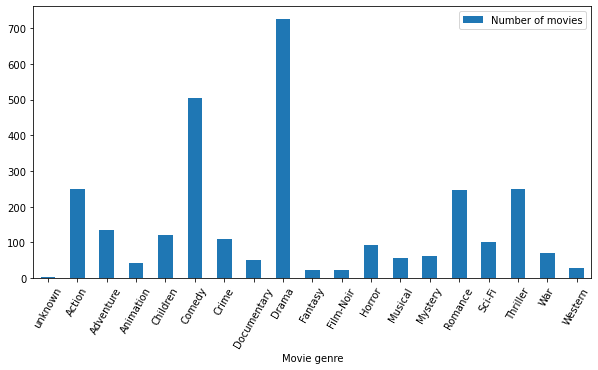

In [284]:
count = []
for i in genre_list:
  genre_based_movies = items[['movie id','movie title',i]]
  genre_based_movies = genre_based_movies[genre_based_movies[i] == 1]
  count.append(len(genre_based_movies))

genre_count = pd.DataFrame({'Movie genre': genre_list, 'Number of movies':count})
ax = genre_count.plot.bar(x='Movie genre', y='Number of movies', rot=60, figsize=(10, 5))

In [285]:
merged_df = pd.merge(df, items, how = 'inner', left_on='item_id', right_on='movie id')
merged_df.head()

,user_id,item_id,rating,timestamp,movie_title,movie id,movie title,release date,video release date,IMDb URL,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),242,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),...,0,0,0,0,0,0,0,0,0,0


In [286]:
genre_dict = {}
for g in genre_list:
    genre_based_movies = merged_df[['movie id','movie title', 'rating',  g]]
    genre_based_movies = genre_based_movies[genre_based_movies[g] == 1]
    genre_dict[g] = genre_based_movies

In [287]:
def recommendations_popularity(genre, k = 10):
        genre_based_movies = genre_dict.get(genre)
        popular_genre_movies = genre_based_movies.groupby(['movie title']).agg({"rating":"count"})['rating'].sort_values(ascending=False)
        popular_movies_ingenre = popular_genre_movies.to_frame()
        popular_movies_ingenre.reset_index(level=0, inplace=True)
        popular_movies_ingenre.columns = ['movie title', 'Number of Users watched']
        print("Top", k,"popular movies of the genre:", genre)
        print("----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ")
        print(popular_movies_ingenre.sort_values('Number of Users watched', ascending=False).head(10))

In [288]:
def recommendations_rating(genre, k = 10):
        genre_based_movies = genre_dict.get(genre)
        highrate_genre_movies = genre_based_movies.groupby(['movie title']).agg({"rating":"mean"})['rating'].sort_values(ascending=False)
        highrate_movies_ingenre = highrate_genre_movies.to_frame()
        highrate_movies_ingenre.reset_index(level=0, inplace=True)
        highrate_movies_ingenre.columns = ['movie title', 'Average Rating']
        print("Top", k,"high rating movies of the genre:", genre)
        print("----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ")
        print(highrate_movies_ingenre.sort_values('Average Rating', ascending=False).head(10))

In [289]:
def recommendations_genre(genre):
    print("Chosen Genre: ", genre)
    print("Recommendation by Popularity: ")
    recommendations_popularity(genre)
    print("Recommendation by Rating: ")
    recommendations_rating(genre)

In [290]:
recommendations_genre("Comedy")

Chosen Genre:  Comedy
Recommendation by Popularity: 
Top 10 popular movies of the genre: Comedy
----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 
                                    movie title  Number of Users watched
0                              Liar Liar (1997)                      485
1                              Toy Story (1995)                      452
2                     Back to the Future (1985)                      350
3  Willy Wonka and the Chocolate Factory (1971)                      326
4                    Princess Bride, The (1987)                      324
5                           Forrest Gump (1994)                      321
6        Monty Python and the Holy Grail (1974)                      316
7                        Full Monty, The (1997)                      315
8                           Men in Black (1997)                      303
9                          Birdcage, The (1996)                      293
Recommendation by Rating: 
T

The Content-Based Filtering comes with several problems
- It is hard to test the recommendation without actual experiment.
- The recommendation is less personalized as it will give the same result for users who choose the same genre.

### PART V: Implementation

I started this project with the intention to complete the required homework. I had lots of fun while analyzing different approaches of recommendation system. Therefore, I decided to further implement the recommendation system.

#### Existing User Recommdation

Based on previous model comparison and other research studies, I believe the Model-Based Collaborative Filtering would be a better model for predicting preferences of the existing users 

In [389]:
# Functionality: generating user-item matrix with NA filled
# Input: 
    # data: rating records
    # n_users: number of users
    # n_items: number of items
    # user_col: column number of user_id, default = 1
    # item_col: column number of item_id, default = 2
    # rating_col: column number of rating_id, default = 3
    
def utility_matrix(data, n_users, n_items, 
                   user_col = 1, item_col = 2, rating_col = 3):
    data_matrix = np.asarray([[np.nan for j in range(n_items)] for i in range(n_users)])
    for row in data.itertuples():
        user = row[user_col]-1
        item = row[item_col]-1
        data_matrix[user][item] = row[rating_col]
    return data_matrix

In [422]:
# Functionality: Using svd to generate predition matrix
# Input: 
    # util_mat: utility matrix where columns are items, rows are users
    # k: number of latent factors used, default = 13
    
def svd_prediction(util_mat, k = 13):
    data_matrix_normed, user_mean, item_mean = matrixTransform(util_mat)
    svd_pred = svd(data_matrix_normed, k,item_mean)
    return pd.DataFrame(svd_pred)

In [439]:
# Functionality: generate recommended movies based on svd prediction
# Input: 
    # pred: prediction matrix generated from svd
    # user_id: user_id
    # numOfMovies: number of movies to recommend, default = 20
    
def svd_generate_movies(pred, user_id, numOfMovies = 20):
    user_rating = pred.iloc[user_id - 1, :]
    toplist = user_rating.sort_values(ascending = False).head(numOfMovies)
    toplist = pd.DataFrame(toplist).reset_index().rename(columns = {"index" : "movie_id"})
    recommend_movies = toplist.movie_id.to_list()
    movie_name = []
    for i in recommend_movies:
        movie_name.append(movie_map.get(i+1))
    return movie_name

In [440]:
user_item_matrix = utility_matrix(df, n_users, n_items)

In [172]:
pred = svd_prediction(user_item_matrix)

In [441]:
# Functionality: print out recommendations to users
# Input: 
    # user_id: user_id

def recommendation_existingUsers(user_id):
    print(" ")
    numOfRecom = int(input("Please enter the number of movie recommendations needed: "))
    print("Recommendation for User: ", user_id)
    # if the svd matrix has not been calculated
    if 'svd_matrix' not in globals():
        global user_item_matrix
        global svd_matrix
        user_item_matrix = utility_matrix(df, n_users, n_items)
        svd_matrix = svd_prediction(user_item_matrix)
    rec = svd_generate_movies(svd_matrix, user_id, numOfRecom)
    print("Top", numOfRecom, "Movie Recommendation")
    print("----- ----- ----- ----- -----")
    for i in range(1, len(rec)+1):
        print(i, "   ", rec[i-1])    

In [442]:
# Test
recommendation_existingUsers(22)

 
Please enter the number of movie recommendations needed: 20
Recommendation for User:  22
Top 20 Movie Recommendation
----- ----- ----- ----- -----
1     Aiqing wansui (1994)
2     Great Day in Harlem, A (1994)
3     Prefontaine (1997)
4     Star Kid (1997)
5     Santa with Muscles (1996)
6     They Made Me a Criminal (1939)
7     Someone Else's America (1995)
8     Marlene Dietrich: Shadow and Light (1996) 
9     Entertaining Angels: The Dorothy Day Story (1996)
10     Saint of Fort Washington, The (1993)
11     Pather Panchali (1955)
12     Maya Lin: A Strong Clear Vision (1994)
13     Some Mother's Son (1996)
14     Anna (1996)
15     Everest (1998)
16     Close Shave, A (1995)
17     Schindler's List (1993)
18     Wrong Trousers, The (1993)
19     Casablanca (1942)
20     Wallace & Gromit: The Best of Aardman Animation (1996)


#### New User Recommdation

As explained previously, collaborative filtering has the cold start problem. Therefore, for new users, Content-Based filtering will be used to implement recommendation system for new users.

In [443]:
# Functionality: generate recommended movies based on chosen genre
    
def recommendation_newUsers():
    print(" ")
    print("Genre Code         Genre")
    for i in range(1, len(genre_list)):
        print("    ",i, "           ", genre_list[i])
    genreCode = int(input("Please enter the code of movie genre you like: "))
    genre = genre_list[genreCode]
    recommendations_genre(genre)

In [444]:
# Test
recommendation_newUsers()

 
Genre Code         Genre
     1             Action
     2             Adventure
     3             Animation
     4             Children
     5             Comedy
     6             Crime
     7             Documentary
     8             Drama
     9             Fantasy
     10             Film-Noir
     11             Horror
     12             Musical
     13             Mystery
     14             Romance
     15             Sci-Fi
     16             Thriller
     17             War
     18             Western
Please enter the code of movie genre you like: 5
Chosen Genre:  Comedy
Recommendation by Popularity: 
Top 10 popular movies of the genre: Comedy
----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- 
                                    movie title  Number of Users watched
0                              Liar Liar (1997)                      485
1                              Toy Story (1995)                      452
2                     Back to the Future 

#### Similar Movie Recommdation

Sometime users would try to find movies similar to one movie. Therefore, the Memory-Item-Based collaborative filtering model would be used to implement recommendation on similar movies

In [449]:
# Functionality: generating user-item matrix with zero filled
def utility_matrix_zero(data, n_users, n_items):
    util_mat = utility_matrix(data, n_users, n_items)
    return pd.DataFrame(util_mat).fillna(0)

In [473]:
def develop_item_knn_model(data, n_users, n_items):
    util_mat = utility_matrix(data, n_users, n_items)
    util_mat = pd.DataFrame(util_mat).fillna(0).T
    util_mat_sparse = csr_matrix(util_mat)
    item_knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    item_knn_model.fit(util_mat_sparse)
    return util_mat, item_knn_model

In [488]:
# Functionality: generate recommended movies based on item similarity
# Input: 
    # movie_id: movie_id
    # numOfMovies: number of movies to recommend, default = 20

def item_generate_movies(movie_id, numOfMovies = 20):
    if 'item_knn_model' not in globals():
        global movie_user_matrix
        global item_knn_model
        movie_user_matrix, item_knn_model = develop_item_knn_model(df, n_users, n_items)
    knn_input = np.asarray([movie_user_matrix.values[movie_id-1]])
    n = min(n_items-1, numOfMovies)
    distances, indices = item_knn_model.kneighbors(knn_input, n_neighbors=n+1)
    similar_item_list = indices.flatten()[1:]
    distance_list = distances.flatten()[1:]
    movie_name = []
    for i in similar_item_list:
        movie_name.append(movie_map.get(i+1))
    return movie_name

In [490]:
movie_list = df["movie_title"].unique()
case_insensitive_movies_list = [i.lower() for i in movie_list]

In [491]:
movie_lower_map = {}
for key in movie_map:
    val = movie_map.get(key).lower()
    movie_lower_map[val] = key

In [492]:
def movies_with_similiar_names(inputName):
    name = ''
    searchRange = case_insensitive_movies_list.copy()
    for word in inputName:
        currentRange = []
        name += word
        for movie in searchRange:
            if (name in movie):
                currentRange.append(movie)
        if len(currentRange) == 0:
            return searchRange
        searchRange = currentRange.copy()
    return searchRange

In [493]:
def recommendation_movies():
    print(" ")
    inputName = input("Please enter the name of the movie you like: ")
    inputName = inputName.lower()
    if inputName in case_insensitive_movies_list:
        movie_id = movie_lower_map.get(inputName)
        numOfRecom = int(input("Please enter the number of movie recommendations needed: "))
        rec = item_generate_movies(movie_id, numOfRecom)
        print("Top", numOfRecom, "Similar to Movie ", movie_map[movie_id])
        print("----- ----- ----- ----- ----- ----- ----- ----- ----- -----")
        for i in range(1, len(rec)+1):
            print(i, "   ", rec[i-1]) 
    else:
        suggest_list = movies_with_similiar_names(inputName)
        if len(suggest_list) == len(movie_list):
            print("The movie name you entered is not in the database.")
        else:
            print("The movie name you entered is not found.")
            print("Please check the following suggestions: ")
            for m in suggest_list:
                print(m)
            qs = input("Please press Q to end, press S to restart searching: ").lower()
            if qs == 'q':
                return
            else:
                recommendation_movies()

In [495]:
# Test
recommendation_movies()

 
Please enter the name of the movie you like: Empire Strikes Back, The (1980)
Please enter the number of movie recommendations needed: 15
Top 15 Similar to Movie  Empire Strikes Back, The (1980)
----- ----- ----- ----- ----- ----- ----- ----- ----- -----
1     Raiders of the Lost Ark (1981)
2     Indiana Jones and the Last Crusade (1989)
3     Back to the Future (1985)
4     Star Wars (1977)
5     Terminator, The (1984)
6     Return of the Jedi (1983)
7     Terminator 2: Judgment Day (1991)
8     Princess Bride, The (1987)
9     Jurassic Park (1993)
10     Fugitive, The (1993)
11     Silence of the Lambs, The (1991)
12     E.T. the Extra-Terrestrial (1982)
13     Star Trek: The Wrath of Khan (1982)
14     Alien (1979)
15     Blade Runner (1982)


### PART V: Chanllenges

### PART V: Going Forward